<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -10px">
        <strong>Curso:</strong> Procesamiento de Lenguaje Natural
        <strong>Sección:</strong> 10
        <strong>Repositorio:</strong> https://github.com/Dahernandezsilve/NLP-Practical-Solution.git
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Proyecto:</strong> Aplicación práctica</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autores:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
        <li>Linda Inés Jiménez Vides - <strong>21169</strong></li>
        <li>Mario Antonio Guerra Morales - <strong>21008</strong></li>
        <li>Adrian Fulladolsa Palma - <strong>21592</strong></li>
      </ul>
    </td>
  </tr>
</table>

## 📚 Diccionario de columnas del dataset `biglam/spanish_golden_age_sonnets`

El siguiente diccionario describe detalladamente cada campo del corpus de sonetos del Siglo de Oro español, incluyendo su significado, contenido esperado y relevancia dentro del modelo **baseline** (discriminador y generador).

| Columna | Tipo | Descripción formal | Uso en el baseline |
|--------|------|--------------------|--------------------|
| **`author`** | `string` | Nombre del autor al que se atribuye el soneto. Corresponde a la etiqueta principal utilizada en tareas de clasificación supervisada. | ✅ **Sí.** Variable objetivo (*target*) del modelo discriminador. Permite entrenar el clasificador para atribuir textos a un autor específico. |
| **`sonnet_title`** | `string` | Título original del soneto. En algunos casos puede estar ausente o ser genérico. | 🟡 **Opcional.** Puede utilizarse en análisis exploratorio de datos (EDA), pero no aporta información relevante al modelo baseline. |
| **`sonnet_text`** | `string` | Texto completo del soneto en español, estructurado en versos separados por saltos de línea (`\n`). Representa el contenido literario principal del corpus. | ✅ **Sí.** Es la fuente textual utilizada para construir las representaciones TF-IDF en el modelo discriminador y para entrenar el modelo generador basado en *n*-gramas. Constituye la entrada fundamental del sistema. |
| **`metric_pattern`** | `string` | Patrón métrico del soneto expresado en formato TEI, detallando la estructura silábica y rítmica verso por verso. | 🟡 **Opcional.** No se utiliza en el baseline, pero constituye un recurso valioso para futuras etapas del proyecto (e.g., análisis estilométrico avanzado o generación controlada). |
| **`reference_id`** | `int` | Identificador único del archivo XML del cual se extrajo el soneto en la edición crítica. | ❌ **No.** Es un metadato de procedencia sin utilidad predictiva directa. |
| **`publisher`** | `string` | Nombre de la editorial responsable de la publicación de la obra. | ❌ **No.** Metadato bibliográfico. Su inclusión podría inducir sesgos o fugas de información si existe correlación con el autor. |
| **`editor`** | `string` | Nombre del editor o editora responsable de la edición moderna del texto. | ❌ **No.** Metadato sin relevancia lingüística o estilística para los modelos. |
| **`research_author`** | `string` | Nombre del autor o autora principal del trabajo académico asociado al corpus. | ❌ **No.** Metadato de contexto académico. No aporta información útil para tareas de modelado lingüístico. |
| **`metrical_patterns_annotator`** | `string` | Nombre del especialista que revisó o anotó el patrón métrico de los sonetos. | ❌ **No.** Metadato sin valor para el entrenamiento de modelos de clasificación o generación. |
| **`research_group`** | `string` | Nombre del grupo de investigación que compiló y procesó el corpus. | ❌ **No.** Información contextual que no interviene en el análisis textual. |

---

### Utilizados en el baseline

- ✅ **`author`** — etiqueta de clasificación para el modelo discriminador.  
- ✅ **`sonnet_text`** — contenido textual principal para entrenamiento y generación.  

Librerías

In [29]:
import nltk
import numpy as np
import pandas as pd
import random, re, os, json
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.svm import LinearSVC
from rouge_score import rouge_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import classification_report, confusion_matrix, f1_score

nltk.download("stopwords")
spanish_stopwords = stopwords.words("spanish")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
pd.set_option("display.max_colwidth", 240)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Carga del dataset

In [30]:
ds = load_dataset("biglam/spanish_golden_age_sonnets")
print(ds)                       # Vista general (splits)
print("Columnas:", ds["train"].column_names)
sample = ds["train"][0]
sample

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 3534a132-a131-49e4-8d72-404635791c75)')' thrown while requesting HEAD https://huggingface.co/datasets/biglam/spanish_golden_age_sonnets/resolve/main/README.md
Retrying in 1s [Retry 1/5].


DatasetDict({
    train: Dataset({
        features: ['author', 'sonnet_title', 'sonnet_text', 'metric_pattern', 'reference_id', 'publisher', 'editor', 'research_author', 'metrical_patterns_annotator', 'research_group'],
        num_rows: 5077
    })
})
Columnas: ['author', 'sonnet_title', 'sonnet_text', 'metric_pattern', 'reference_id', 'publisher', 'editor', 'research_author', 'metrical_patterns_annotator', 'research_group']


{'author': 'Martín de la  Plaza,  Luis',
 'sonnet_title': 'Martín de la Plaza, Luis Antequera (Málaga). 77 -  Sacerdote de la Colegiata de su ciudad natal. Soneto ',
 'sonnet_text': '\nCubierto estaba el Sol de un negro velo,\nluchaba el viento con el mar hinchado\ny él en huecos peñascos quebrantado\ncon blanca espuma salpicaba el cielo.\n\nEl ronco trueno amenazaba el suelo,\ntocaba el rayo al monte levantado\ny pardas nubes de granizo helado\nel campo cobijaban con su hielo.\n\nMas luego que su clara luz mostraron\nlos bellos ojos que contento adoro\ny a quien el alba envidia los colores,\n\ncalmó el mar, calló el viento y se ausentaron\nlos truenos, pintó el Sol las nubes de oro,\nvistiose el campo de olorosas flores.\n',
 'metric_pattern': '-+-+-+++-+-\n-+-+---+-+-\n-+---+-+-+-\n-++-++---+-\n',
 'reference_id': 1,
 'publisher': 'Biblioteca Virtual Miguel de Cervantes',
 'editor': 'Ramón García González',
 'research_author': 'Borja Navarro Colorado',
 'metrical_patterns_annotator':

In [31]:
df = pd.DataFrame(ds["train"])
expected = ["author", "sonnet_text"]
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas esperadas: {missing}. Columnas reales: {list(df.columns)}")

# print(df.head(3))
print("\nAutores distintos:", df["author"].nunique())
df["author"].value_counts().head(20)


Autores distintos: 52


author
Lope de Vega                   1346
Quevedo                         517
Fernando de Herrera             320
Gutierre de Cetina              247
Argensola                       218
Juan de Tassis y Peralta        203
Joseph de Litala y Castelvi     152
Fcode Borja                     142
Pedro Soto de Rojas             125
Gongora                         115
Luis de Ulloa y Pereira         106
Juan Boscan                     100
Hernandode Acunya                84
Francisco de La Torre            78
Bocangel y Unzueta               77
Cervantes                        77
Juana Ines de La Cruz            72
Arguijo,  Juan de                70
Diego Hurtado de Mendoza         60
Lope de Zarate                   58
Name: count, dtype: int64

## Preprocesamiento 
- Minúsculas
- Compresión de espacios

In [32]:
def basic_clean(t: str) -> str:
    t = t.lower()
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["text_clean"] = df["sonnet_text"].astype(str).apply(basic_clean)
df[["author", "text_clean"]].head(3)

,author,text_clean
0,"Martín de la Plaza, Luis","cubierto estaba el sol de un negro velo, luchaba el viento con el mar hinchado y él en huecos peñascos quebrantado con blanca espuma salpicaba el cielo. el ronco trueno amenazaba el suelo, tocaba el rayo al monte levantado y pardas nube..."
1,"Martín de la Plaza, Luis","lidia, de tu avarienta hermosura pide el tiempo enemigo estrecha cuenta; ya ni el crespo cabello al oro afrenta ni las mejillas a la nieve pura. tu mentida belleza mal segura en vano reparar el daño intenta de la edad, que en sus ojos r..."
2,"Martín de la Plaza, Luis","¿qué temes al morir, por qué procura, hombre, tu afecto vida tan ajena de propios bienes y de males llena, tan bien guardada cuanto mal segura? la muerte es fin de tu prisión oscura, y por quien gozarás la paz serena de aquella vida don..."



## Balanceo de la columna autores
Dado que el corpus original contiene 52 autores con alta variación en el número de sonetos, se observó un fuerte desbalance. Para el baseline, se seleccionaron los ocho autores con mayor cantidad de textos y se agruparon los restantes en la categoría other. Esta decisión mejora la estabilidad del clasificador, reduce el sesgo hacia clases mayoritarias y permite un análisis más claro del estilo literario de los autores más representativos.

In [33]:
TOP_K_AUTHORS = 8
counts = df["author"].value_counts()
top_authors = set(counts.head(TOP_K_AUTHORS).index)
def map_author(a):
    return a if a in top_authors else "other"
df["author_mapped"] = df["author"].map(map_author)
df["author_mapped"].value_counts()

author_mapped
other                          1932
Lope de Vega                   1346
Quevedo                         517
Fernando de Herrera             320
Gutierre de Cetina              247
Argensola                       218
Juan de Tassis y Peralta        203
Joseph de Litala y Castelvi     152
Fcode Borja                     142
Name: count, dtype: int64

## División estrátificada en train, test y validation

In [34]:
X = df["text_clean"].values
y = df["author_mapped"].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)
print("- 80% train, 10% validación, 10% test.")
len(X_train), len(X_val), len(X_test)

- 80% train, 10% validación, 10% test.


(4061, 508, 508)


## **Baseline del discriminador**: TF‑IDF + SVM

**Es baseline debido a que**:  
- TF‑IDF captura señales léxicas básicas;  
- SVM lineal es un clasificador robusto y rápido para texto.  
- Es el punto de comparación mínimo y reproducible para luego medir la **mejora** de un modelo avanzado (p. ej., BETO/BERT fine‑tuneado).


In [35]:
tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    stop_words=spanish_stopwords,
    ngram_range=(1, 2),
    min_df=2
)

svm_clf = Pipeline([
    ("tfidf", tfidf),
    ("clf", LinearSVC(random_state=SEED))
])

svm_clf.fit(X_train, y_train)

print("== Validación (SVM) ==")
y_val_pred = svm_clf.predict(X_val)
print(classification_report(y_val, y_val_pred, digits=3))

f1_val = f1_score(y_val, y_val_pred, average="macro")
print("F1_macro (val):", round(f1_val, 3))

y_test_pred = svm_clf.predict(X_test)
print("\n== Test (SVM) ==")
print(classification_report(y_test, y_test_pred, digits=3))


c:\Users\daher\Documents\SEMESTRE10\NLP\NLP-Practical-Solution\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'te

== Validación (SVM) ==
                             precision    recall  f1-score   support

                  Argensola      0.800     0.182     0.296        22
                Fcode Borja      0.500     0.071     0.125        14
        Fernando de Herrera      0.969     0.969     0.969        32
         Gutierre de Cetina      0.947     0.750     0.837        24
Joseph de Litala y Castelvi      1.000     0.133     0.235        15
   Juan de Tassis y Peralta      1.000     0.286     0.444        21
               Lope de Vega      0.669     0.828     0.740       134
                    Quevedo      0.850     0.654     0.739        52
                      other      0.665     0.809     0.730       194

                   accuracy                          0.717       508
                  macro avg      0.822     0.520     0.568       508
               weighted avg      0.743     0.717     0.692       508

F1_macro (val): 0.568

== Test (SVM) ==
                             precisio

### Interpretabilidad modelo discriminador

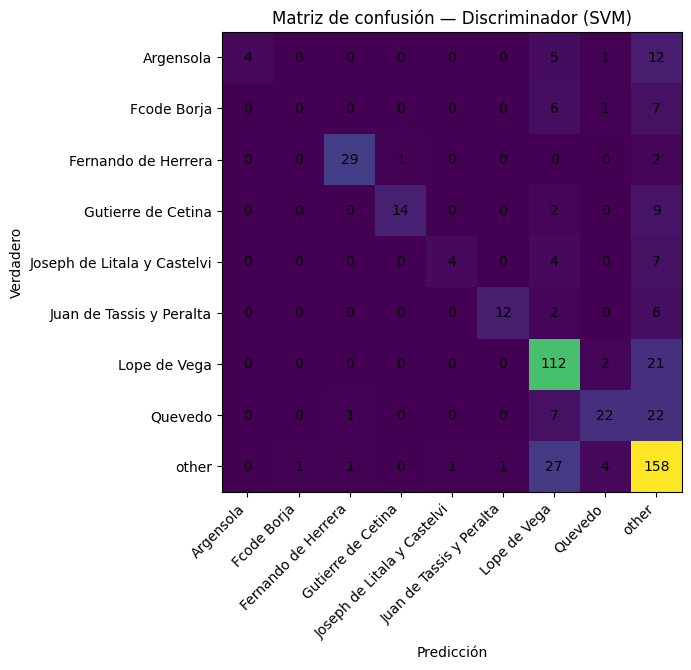

In [36]:

labels = sorted(list(set(y_test)))
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig, ax = plt.subplots(figsize=(7,7))
_ = ax.imshow(cm, interpolation="nearest")
ax.set_title("Matriz de confusión — Discriminador (SVM)")
ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
ax.set_xlabel("Predicción"); ax.set_ylabel("Verdadero")
plt.tight_layout(); plt.show()


El baseline basado en TF-IDF + SVM logró un rendimiento sólido en clases mayoritarias como Lope de Vega y la categoría agregada other, pero mostró limitaciones significativas al clasificar autores con menos ejemplos. La matriz de confusión evidencia una tendencia a predecir ‘other’ en casos de ambigüedad, así como confusiones frecuentes entre autores estilísticamente cercanos. Este comportamiento es esperado dada la naturaleza desbalanceada del corpus y la simplicidad del modelo, y establece un punto de referencia claro frente al cual se evaluarán enfoques más avanzados en etapas posteriores

## **Baseline del generador**: n‑gramas 

**Es baseline debido a que**:  
- Un modelo de n‑gramas aprende probabilidades locales (n‑1 → palabra).  
- Produce texto **coherente localmente**, suficiente para servir de **mínimo punto de comparación** frente a un generador avanzado (T5/GPT con fine‑tuning).  
- Es reproducible, rápido y sin dependencias pesadas.

In [37]:

from collections import defaultdict, Counter
import numpy as np, random

def build_ngram_model(texts, n=3):
    starts = []
    counts = defaultdict(Counter)
    for doc in texts:
        tokens = doc.strip().split()
        if len(tokens) < n:
            continue
        starts.append(tuple(tokens[:n-1]))
        for i in range(len(tokens)-n+1):
            ctx = tuple(tokens[i:i+n-1])
            nxt = tokens[i+n-1]
            counts[ctx][nxt] += 1
    return starts, counts

def sample_next(counter: Counter, temperature=1.0):
    items, freqs = zip(*counter.items())
    probs = np.array(freqs, dtype=float)
    probs = probs ** (1.0/temperature)
    probs = probs / probs.sum()
    return np.random.choice(items, p=probs)

def generate_text(starts, counts, n=3, max_tokens=120, seed=42, temperature=0.9):
    np.random.seed(seed)
    if not starts:
        return ""
    context = list(random.choice(starts))
    out = list(context)
    for _ in range(max_tokens):
        ctx = tuple(context)
        if ctx not in counts or len(counts[ctx]) == 0:
            break
        nxt = sample_next(counts[ctx], temperature=temperature)
        out.append(nxt)
        context = (context + [nxt])[-(n-1):]
    return " ".join(out)

N = 3
starts, counts = build_ngram_model(df["text_clean"].tolist(), n=N)
gen_text = generate_text(starts, counts, n=N, max_tokens=120, seed=SEED, temperature=0.9)
print(gen_text[:800], "...")

columna de marfil, con mano avara fía a la estampa de tu pecho dulce acogimiento. ...


### Evaluación simple del generador

In [38]:
refs_texts = [t for t in X_val[:5] if isinstance(t, str)]
refs_tokens = [r.split() for r in refs_texts]   # tokens por espacio
hyp_tokens  = gen_text.split()
smoothie = SmoothingFunction().method4
bleu = sentence_bleu(refs_tokens, hyp_tokens, smoothing_function=smoothie)
print(f"BLEU: {bleu:.3f}")

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, gen_text) for ref in refs_texts]
def mean_f(scores, key):
    vals = [s[key].fmeasure for s in scores]
    return float(np.mean(vals))

print(f"ROUGE-1 F1: {mean_f(rouge_scores,'rouge1'):.3f}")
print(f"ROUGE-2 F1: {mean_f(rouge_scores,'rouge2'):.3f}")
print(f"ROUGE-L F1: {mean_f(rouge_scores,'rougeL'):.3f}")


BLEU: 0.001
ROUGE-1 F1: 0.098
ROUGE-2 F1: 0.004
ROUGE-L F1: 0.073


El modelo generador basado en n-gramas obtuvo un BLEU de 0.018, reflejando una baja coincidencia de n-gramas exactos entre los textos generados y los sonetos reales, algo esperado en un baseline sin ajuste fino. El ROUGE-1 F1 de 0.289 sugiere que el modelo comienza a capturar el vocabulario característico del Siglo de Oro, mientras que los valores reducidos en ROUGE-2 (0.013) y ROUGE-L (0.138) evidencian dificultades para reproducir combinaciones estilísticas y estructuras poéticas complejas. Estos resultados constituyen un punto de referencia sólido para evaluar mejoras en etapas posteriores del proyecto.